# Fair Pricing of an Autocallable Barrier Reverse Convertible 

Monte Carlo method is applied to obtain the fair price of ABRC at Initial Fixing Date 
(i.e. last day of Subscription Period)

In [570]:
import pandas as pd
import numpy as np
import yfinance as yf

# retrieve daily lowest prices of CAT and DE from yahoo finance.
# prices are adjusted for dividends and stock splits
CAT = yf.Ticker("CAT")
DE  = yf.Ticker("DE")
cat = CAT.history(start='2018-04-16', end='2021-04-09', action=False).iloc[:,2:3]
de  = DE.history(start='2018-04-16', end='2021-04-09', action=False).iloc[:,2:3]
# calculate log returns
cat['Log_Return'] = np.log(cat['Low']/cat['Low'].shift(1))
de['Log_Return'] = np.log(de['Low']/de['Low'].shift(1))

In [2]:
# make sure that prices are quoted in USD
print(CAT.info['currency'])
print(DE.info['currency'])

USD
USD


In [522]:
cat

,Low,Log_Return
Date,,
2018-04-16,138.043057,NaN
2018-04-17,140.550750,0.018003
2018-04-18,141.983707,0.010144
2018-04-19,141.423391,-0.003954
2018-04-20,140.667547,-0.005359
...,...,...
2021-04-01,226.565854,-0.005521
2021-04-05,231.324344,0.020785
2021-04-06,229.193968,-0.009252


In [523]:
de

,Low,Log_Return
Date,,
2018-04-16,140.704683,NaN
2018-04-17,141.520706,0.005783
2018-04-18,141.767423,0.001742
2018-04-19,139.006266,-0.019669
2018-04-20,138.816475,-0.001366
...,...,...
2021-04-01,369.290009,0.002630
2021-04-05,373.910004,0.012433
2021-04-06,375.019989,0.002964


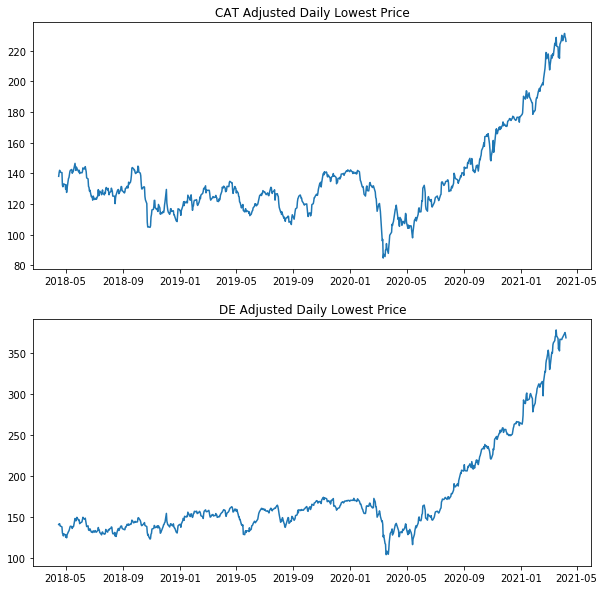

In [501]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2,1,figsize=(10,10))

axes[0].plot(cat['Low'])
axes[0].set_title('CAT Adjusted Daily Lowest Price')
axes[1].plot(de['Low'])
axes[1].set_title('DE Adjusted Daily Lowest Price')
# plt.show()

plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\historical_price.png')

C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Su

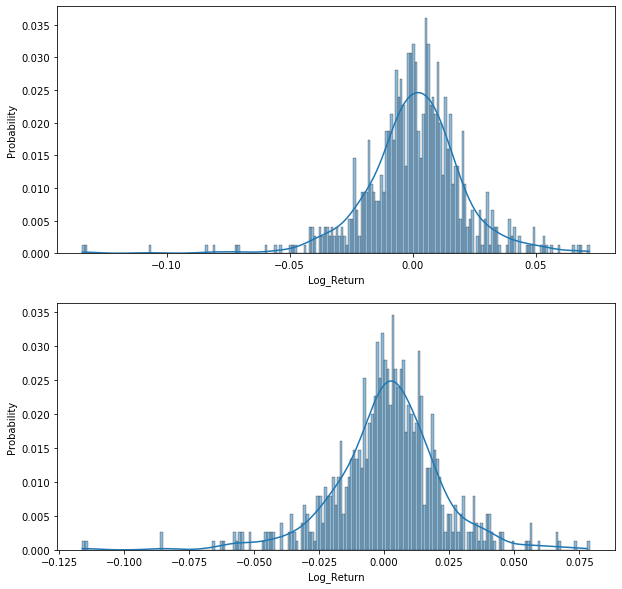

In [8]:
fig, axes = plt.subplots(2,1,figsize=(10,10))

sns.histplot(cat['Log_Return'], stat='probability', binwidth=0.001, kde=True, ax=axes[0])
sns.histplot(de['Log_Return'], stat='probability', binwidth=0.001, kde=True, ax=axes[1])

plt.show()

Assume that the adjusted daily lowest prices follow correlated Geometric Brownian Motion, now we calculate the drift and volatility of each underlying stock.

In [574]:
# Assume that there are in average 252 trading days in a year

# drift
mean1 = cat['Log_Return'].mean()
sig1 = np.nanstd(cat['Log_Return'], ddof=1)/np.sqrt(1/252)
mu1 = mean1*252 + 0.5*sig1**2

mean2 = de['Log_Return'].mean()
sig2 = np.nanstd(de['Log_Return'], ddof=1)/np.sqrt(1/252)
mu2 = mean2*252 + 0.5*sig2**2

print('Drift and Volatility of GBM of CAT: ', round(mu1,4), round(sig1,4),'\n')
print('Drift and Volatility of GBM of DE: ', round(mu2,4), round(sig2,4))
# correlation between log return

Drift and Volatility of GBM of CAT:  0.2203 0.33 

Drift and Volatility of GBM of DE:  0.3791 0.3333


In [10]:
# correlation
rho = np.corrcoef(cat['Log_Return'][1:], de['Log_Return'][1:])[0][1]
print('Correlation between log returns of CAT, DE: ', round(rho,4))

Correlation between log returns of CAT, DE:  0.7477


In [356]:
from datetime import datetime
import pandas_market_calendars as mcal # conda install -c conda-forge pandas_market_calendars

# get holidays in NYSE from Initial Fixing Date to Final Redemption Date
today, end_date = np.datetime64('2021-04-08'), np.datetime64('2022-07-15')
nyse = mcal.get_calendar('NYSE')
holidays = list(nyse.holidays().holidays) # as a list of datetime objects
holidays = [day for day in holidays if (day>=today) & (day <= end_date)]

# time to maturity (in days excluding holidays)
T = np.busday_count(today,end_date,holidays=holidays)

str_to_date = lambda date: datetime.strptime(date, '%Y-%m-%d').date()
# Trigger Observation Dates and Interest Payment Dates as lists of datetime.date objects
rdp_date = [str_to_date(date) for date in ['2021-10-12','2022-01-12','2022-04-12']]
cp_date = [str_to_date(date) for date in ['2021-07-15','2021-10-15','2022-01-18','2022-04-15','2022-07-15']]
sorted_date = sorted(rdp_date+cp_date)
# map trigger observation dates to the next redemption dates
early_rdp = lambda date: cp_date[rdp_date.index(date)+1]
# the next interest payment date for each early redemption
final_cp = list(map(early_rdp, rdp_date))

# counting function which returns relevent day counts
# For TOD, the day counts will be the number of trading days from today to TOD
# For IPD, it will be the number of days from today to IPD, excluding holidays
today = today.astype(datetime)
cpdaycount = lambda x: (x-today).days - len([day for day in holidays if (day.astype(datetime) <= x)])
daycount = lambda date: np.busday_count(today,date,holidays=holidays) if date in rdp_date else cpdaycount(date)


321


datetime.date(2022, 1, 18)

In [518]:
from math import floor
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
r = 0.0023 # risk-free interest rate
pr = 0.0825 # coupon rate
R1, R2 = 4.3388, 2.6733 # ratio of worst case scenario
trans = 0.0005 # transaction fee

N = 10**5 # number of simulation
# we need to simulate 1) daily lowest prices during barrier observation period (2021-4-9 to 2022-7-12)
# 2) final levels (closing prices on 2022-7-12)
# 3) settlement prices at maturity (2022-7-15)
# In the following, S1[i,:], S2[i,:] will be the vector of prices of each simulation on i-th business day after today
S1 = np.ones((T-1,N))*cat.iloc[-1,0]
S2 = np.ones((T-1,N))*de.iloc[-1,0]
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
W1,W2,W3,W4 = np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N)
dt = 1/360
for i in range(T-3):
    S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
# daily lowest price at maturity
dt = 3/360
S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
S2[-1,:] = S2[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
# adjustment from daily lowest prices to settlement prices
S1[-1,:] *= 1+abs(W1)
S2[-1,:] *= 1+abs(W2)
# adjustment for final level (from lowest prices to closing prices)
S1[-2,:] *= 1+abs(W3)
S2[-2,:] *= 1+abs(W4)
# values of redemption and cumulative coupon payments for each simulation
rdp, cp = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
        # if rdp==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
    else:
        t = daycount(date)
        cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
        
# update the values at maturity
# condition of Barrier Event
barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2) 
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
# time to maturity (days)
t = daycount(cp_date[-1]) 
worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)

In [519]:
total = rdp+cp # total present value of cashflows of each simulation
price = np.mean(total)
var = np.var(total, ddof=1)/N

print('Fair price of the 8.25% Autocallable Barrier Reverse Convertibles (CAT, DE): ', round(price,4))
print('Variance of the estimator: ', round(var,4))

Fair price of the 8.25% Autocallable Barrier Reverse Convertibles (CAT, DE):  1045.9308
Variance of the estimator:  0.0596


In [530]:
t = daycount(cp_date[-1]) # time to maturity (days)
early_index = np.where(rdp>F*np.exp(-r*t/360)) # index of simulations with early redemption
early1 = np.where(rdp==F*np.exp(-r*daycount(cp_date[1])/360))
early2 = np.where(rdp==F*np.exp(-r*daycount(cp_date[2])/360))
early3 = np.where(rdp==F*np.exp(-r*daycount(cp_date[3])/360))
final_index = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations with final redemption
ok_index = np.where(rdp==F*np.exp(-r*t/360)) # index of simulations with final redemption but no worst case scenario
worst_index = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations with worst case scenario

print('Value of ABRC if:\n')
print('redeemed on Oct 15, 2021:', round(total[early1][0],4))
print('redeemed on Jan 18, 2022:', round(total[early2][0],4))
print('redeemed on Apr 15, 2022:', round(total[early3][0],4))
print('final redemption but no worst case scenario:', round(total[ok_index][0],4))

print('\nProbability of early redemption: ', len(early_index[0])/N)
print('Probability of redemption on Oct 15, 2021: ', len(early1[0])/N)
print('Probability of redemption on Jan 12, 2021: ', len(early2[0])/N)
print('Probability of redemption on Apr 15, 2021: ', len(early3[0])/N)
# print('Expected Value of the ABRC given final redemption: ', round(np.mean(total[early_index]),4))
# print('\nProbability of final redemption: ', len(final_index[0])/N)
# print('Expected Value of the ABRC given no early redemption: ', round(np.mean(total[final_index]),4))
# print('Probability of final redemption but not worst case scenario: ', (len(final_index[0])-len(worst_index[0]))/N)
# print('Expected Value of the ABRC given final redemption but no worst case scenario: ', round(np.mean(total[ok_index]),4))
print('\nProbability of Worst Case Scenario: ', len(worst_index[0])/N)
print('Expected Value of the ABRC given Worst Case Scenario: ', round(np.mean(total[worst_index]),4))

Value of ABRC if:

redeemed on Oct 15, 2021: 1040.0187
redeemed on Jan 18, 2022: 1060.0266
redeemed on Apr 15, 2022: 1080.0619
final redemption but no worst case scenario: 1100.0603

Probability of early redemption:  0.70966
Probability of redemption on Oct 15, 2021:  0.51908
Probability of redemption on Jan 12, 2021:  0.1216
Probability of redemption on Apr 15, 2021:  0.06891

Probability of Worst Case Scenario:  0.04474
Expected Value of the ABRC given Worst Case Scenario:  726.3758


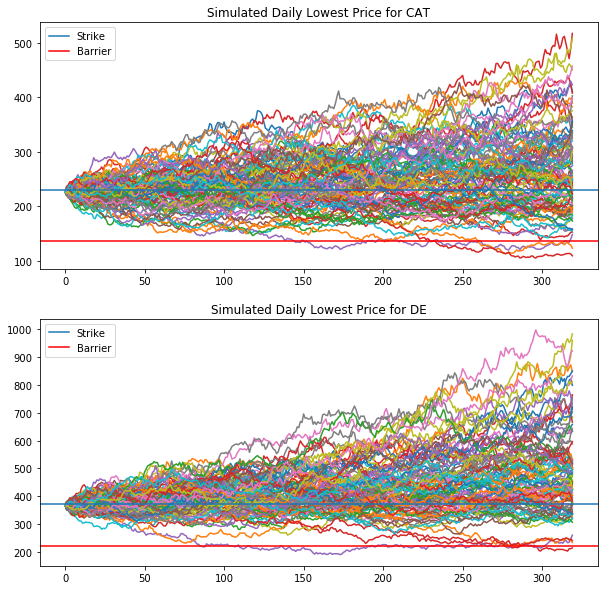

In [441]:
fig,axes = plt.subplots(2,1,figsize=(10,10))

axes[0].plot(S1[:,:100])
axes[0].axhline(X1, label='Strike')
axes[0].axhline(B1, color='r', label='Barrier')
axes[0].legend()
axes[0].set_title('Simulated Daily Lowest Price for CAT')

axes[1].plot(S2[:,:100])
axes[1].axhline(X2, label='Strike')
axes[1].axhline(B2, color='r', label='Barrier')
axes[1].legend()
axes[1].set_title('Simulated Daily Lowest Price for DE')

plt.show()
# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\simulated_price.png')

# Control Variate

In [520]:
# We use the ABRC on only CAT as the known statistics in control variate
# Here the ABRC has all the same conditions except there's only one underlying

rdp1, cp1 = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = (S1[i,:]>=X1) # condition of early redemption
        # if rdp1==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp1 += np.where(rdp1==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp1 = np.where(rdp1==F, np.where(condition, rdp1*np.exp(-r*t/360), rdp1), rdp1)
    else:
        t = daycount(date)
        cp1 += np.where(rdp1==F, F*0.25*pr*np.exp(-r*t/360), 0)
# update the values at maturity
# condition of Barrier Event
barrier = np.min(S1[:-1,:],axis=0)<=B1
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and(barrier, S1[-2,:]>=X1)
t = daycount(cp_date[-1]) # time to maturity (days)
worst_payoff = np.exp(-r*t/360)*(R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1
rdp1 = np.where(rdp1==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp1)

values = cp1 + rdp1
print('Correlation between Product and ABRC with CAT:', np.corrcoef(total,values)[0,1])
b = np.corrcoef(total,values)[0,1]*np.std(total)/np.std(values)
print('ABRC price by control variate:', round(np.mean(total-b*(values-np.mean(values))),4))
print('variance of the estimator:', round(np.var(total-b*(values-np.mean(values)),ddof=1)/N,4))

Correlation between Product and ABRC with CAT: 0.916361246668472
ABRC price by control variate: 1045.9308
variance of the estimator: 0.0096


In [517]:
# We use the ABRC on only DE as the known statistics in control variate
# Here the ABRC has all the same conditions except there's only one underlying

rdp1, cp1 = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = (S2[i,:]>=X2) # condition of early redemption
        # if rdp1==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp1 += np.where(rdp1==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp1 = np.where(rdp1==F, np.where(condition, rdp1*np.exp(-r*t/360), rdp1), rdp1)
    else:
        t = daycount(date)
        cp1 += np.where(rdp1==F, F*0.25*pr*np.exp(-r*t/360), 0)
# update the values at maturity
# condition of Barrier Event
barrier = np.min(S2[:-1,:],axis=0)<=B2
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and(barrier, S2[-2,:]>=X2)
t = daycount(cp_date[-1]) # time to maturity (days)
worst_payoff = np.exp(-r*t/360)*(R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2
rdp1 = np.where(rdp1==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp1)

values = cp1 + rdp1
print('Correlation between Product and ABRC with CAT:', np.corrcoef(total,values)[0,1])
b = np.corrcoef(total,values)[0,1]*np.std(total)/np.std(values)
print('ABRC price by control variate:', round(np.mean(total-b*(values-np.mean(values))),4))
print('variance of the estimator:', round(np.var(total-b*(values-np.mean(values)),ddof=1)/N,4))

Correlation between Product and ABRC with CAT: 0.5061438276165394
ABRC price by control variate: 1045.9623
variance of the estimator: 0.0439


# Antithetic variate

In [665]:
# face value
F = 1000
# strike price
X1 = 230.48
X2 = 374.07
# barrier price
B1 = X1*0.59
B2 = X2*0.59
# interest rate
r = 0.0023

N = 5*10**4
S1 = np.ones((T-1,N))*cat.iloc[-1,0]
S2 = np.ones((T-1,N))*de.iloc[-1,0]
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
W1,W2,W3,W4 = np.random.normal(0,0.01),np.random.normal(0,0.01),np.random.normal(0,0.01),np.random.normal(0,0.01)
trans = 0.0005 # transaction fee

def ABRC(pr,Z1,Z2):
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    # as we are simulating daily lowest prices, we adjust the settlement price at maturity by some random number
    S1[-1,:] *= 1+abs(W1)
    S2[-1,:] *= 1+abs(W2)
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+abs(W3)
    S2[-2,:] *= 1+abs(W4)

    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # business days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
        else:
            t = daycount(date)
            cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
    # update the values at maturity
    rdp2 = rdp.copy() 
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2)
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    t = daycount(cp_date[-1]) # time to maturity (days)
    worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)
    total = rdp+cp
    
    final_index = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations that reach final redemption
    pb_final = len(final_index[0])/N
    ev_final = np.mean(total[final_index]) # expected value of worst case scenario
    
    worst_index = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations for worst case scenario
    pb_worst = len(worst_index[0])/N
    ev_worst = np.mean(total[worst_index]) # expected value of final redemption
    
    summary = {'Probability of Final Redemption':round(pb_final,2), 'Expected Value of Final Redemption':round(ev_final,2),
               'Probability of Worst Case Scenario':round(pb_worst,3), 'Expected Value of Worst Case Scenario':round(ev_worst,2)}
    return(total, summary)

first = ABRC(pr=pr,Z1=Z1,Z2=Z2)
second = ABRC(pr=pr,Z1=Z1,Z2=-Z2)
prices1 = first[0]
prices2 = second[0]
corr = np.corrcoef(prices1,prices2)[0,1]
prices = np.concatenate((prices1,prices2))

print('Correlation between antithetic simulations:', corr)
print('ABRC price by antithetic variate:', np.mean(prices))
print('Variance of estimators:', np.var(prices,ddof=1)/len(prices))

# coupons = np.linspace(0.05,0.1,num=41)
# result = [ABRC(x) for x in coupons]

Correlation between antithetic simulations: 0.8996827601081229
ABRC price by antithetic variate: 1053.5488191342426
Variance of estimators: 0.05138353149207976


In [666]:
# comparison of antithetic simulations
print(np.mean(prices1), np.mean(prices2))
print(first[1])
print(second[1])

1048.7523473237377 1058.3452909447478
{'Probability of Final Redemption': 0.29, 'Expected Value of Final Redemption': 1052.42, 'Probability of Worst Case Scenario': 0.042, 'Expected Value of Worst Case Scenario': 777.41}
{'Probability of Final Redemption': 0.42, 'Expected Value of Final Redemption': 1065.04, 'Probability of Worst Case Scenario': 0.05, 'Expected Value of Worst Case Scenario': 804.71}


# Calculate fair prices of ABRC with a range of coupon rates

In [463]:
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
r = 0.0023 # interest rate
trans = 0.0005 # transaction fee

N = 10**5
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
# generate four normal r.v. for adjustment from daily lowest prices to final levels and settlement prices
W1 = abs(np.random.normal(0,0.01,N))
W2 = abs(np.random.normal(0,0.01,N))
W3 = abs(np.random.normal(0,0.01,N))
W4 = abs(np.random.normal(0,0.01,N))

def ABRC(pr):
    S1 = np.ones((T-1,N))*cat.iloc[-1,0] # prices on Initial Fixing Date
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    # as we are simulating daily lowest prices, we adjust the settlement price at maturity by some random number
    S1[-1,:] *= 1+W1
    S2[-1,:] *= 1+W2
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+W3
    S2[-2,:] *= 1+W4

    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # business days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
        else:
            t = daycount(date)
            cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
    # update the values at maturity
    rdp2 = rdp.copy() 
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2)
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    t = daycount(cp_date[-1]) # time to maturity (days)
    worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)
    
    total = rdp+cp
    price = np.mean(total) # fair price
    var = np.var(total,ddof=1)/N # variance of estimator
    
    t = daycount(cp_date[-1]) # time to maturity (days)
    early = np.where(rdp>F*np.exp(-r*t/360)) # index of simulations with early redemption
    final = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations with final redemption
    ok = np.where(rdp==F*np.exp(-r*t/360)) # index of simulations with final redemption but no worst case scenario
    worst = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations with worst case scenario
    
    p_early = np.mean(total[early])
    p_final = np.mean(total[final])
    p_ok = np.mean(total[ok])
    p_worst = np.mean(total[worst])

    return(price,var,p_early,p_final,p_ok,p_worst)

coupons = np.linspace(0.05,0.1,num=41)
result = [ABRC(x) for x in coupons]
prices = [i[0] for i in result]
variances = [i[1] for i in result]

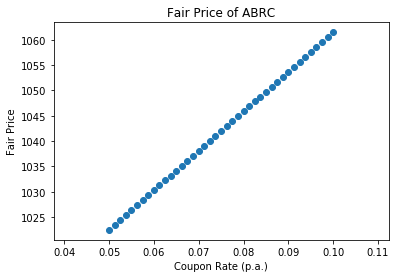

In [473]:
plt.scatter(coupons,prices)
plt.title('Fair Price of ABRC')
plt.xlabel('Coupon Rate (p.a.)')
plt.ylabel('Fair Price')

plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\price_coupon.png')

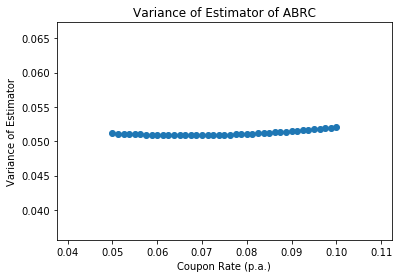

In [474]:
plt.scatter(coupons,variances)
plt.title('Variance of Estimator of ABRC')
plt.xlabel('Coupon Rate (p.a.)')
plt.ylabel('Variance of Estimator')

plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\variance_coupon.png')

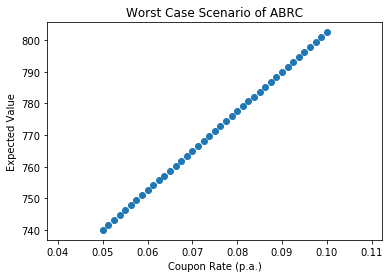

In [477]:
worst_value = [[i[5] for i in result]]

plt.scatter(coupons,worst_ev)
plt.title('Worst Case Scenario of ABRC')
plt.xlabel('Coupon Rate (p.a.)')
plt.ylabel('Expected Value')

plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\worst_coupon.png')

# Stress Testing

In [586]:
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
r = 0.0023 # interest rate
trans = 0.0005 # transaction fee

def ABRC_stress(pr,level=0):
    N = 10**5
    S1 = np.ones((T-1,N))*cat.iloc[-1,0] # prices on Initial Fixing Date
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    sigma1 = sig1*(1+level) # increase the volatility terms in GBM by level 
    sigma2 = sig2*(1+level)
    
    Z1 = np.random.normal(0,1,size=(T-2,N))
    Z2 = np.random.normal(0,1,size=(T-2,N))
    Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
    # generate four normal r.v. for adjustment from daily lowest prices to final levels and settlement prices
    W1 = abs(np.random.normal(0,0.01*(1+level),N))
    W2 = abs(np.random.normal(0,0.01*(1+level),N))
    W3 = abs(np.random.normal(0,0.01*(1+level),N))
    W4 = abs(np.random.normal(0,0.01*(1+level),N))
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sigma1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sigma2*np.sqrt(dt)*Z2[i,:])
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sigma1*np.sqrt(dt)*Z1[i,:])
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sigma1*np.sqrt(dt)*Z1[i,:])
    # as we are simulating daily lowest prices, we adjust the settlement price at maturity by some random number
    S1[-1,:] *= 1+W1
    S2[-1,:] *= 1+W2
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+W3
    S2[-2,:] *= 1+W4

    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # business days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
        else:
            t = daycount(date)
            cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
    # update the values at maturity
    rdp2 = rdp.copy() 
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2)
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    t = daycount(cp_date[-1]) # time to maturity (days)
    worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)
    
    total = rdp+cp
    price = np.mean(total) # fair price
    var = np.var(total,ddof=1)/N # variance of estimator
    
    t = daycount(cp_date[-1]) # time to maturity (days)
    early = np.where(rdp>F*np.exp(-r*t/360)) # index of simulations with early redemption
    final = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations with final redemption
    ok = np.where(rdp==F*np.exp(-r*t/360)) # index of simulations with final redemption but no worst case scenario
    worst = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations with worst case scenario
    
    p_early = len(early[0])/N
#     p_final = len(final[0])/N
#     p_ok = len(ok[0])/N
    p_worst = len(worst[0])/N
    
    ev_early = np.mean(total[early])
    ev_final = np.mean(total[final])
    ev_ok = np.mean(total[ok])
    ev_worst = np.mean(total[worst])
    
    return(price,var,p_worst,ev_worst,p_early,ev_early)



In [629]:
# stress function that returns characteristics of ABRC given coupon rate and stress level 
stress = lambda x: ABRC_stress(pr=x[0],level=x[1])

param = np.mgrid[0.05:0.1025:0.0025, 0:1.1:0.1].reshape(2,-1).T
result = np.array(list(map(stress,param)))
# result is a M by 4 matrix where each row is a vector 
# [fair price,variance of estimator, probability of Worst Case Scenario, expected value given Worst Case Scenario]
# M = a*b is the size of parameters where a: number of coupon rates, b: number of stress levels

In [662]:
fair_prices = np.array([[i[0] for i in result]])
ev_worst = np.array([[i[3] for i in result]])
triple = np.concatenate((param,fair_prices.T),axis=1) # (coupon, stress level, fair price)
triple2 = np.concatenate((param,ev_worst.T),axis=1)

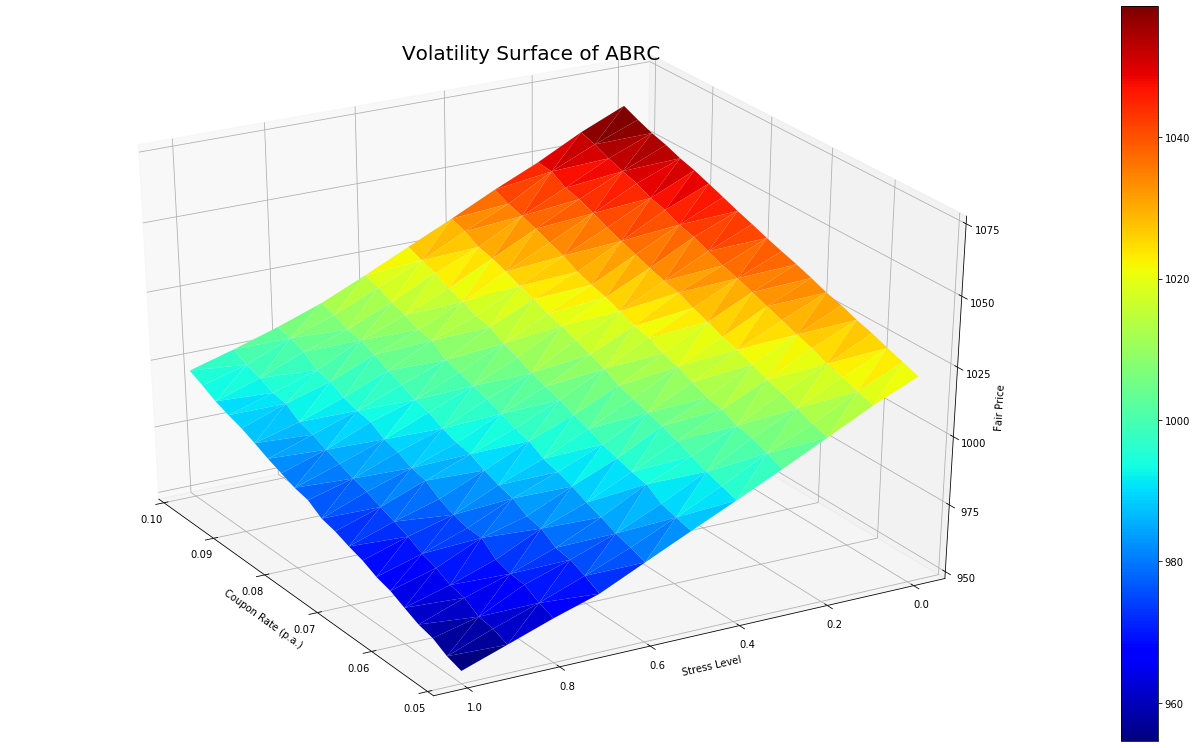

In [658]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')

Xs = triple[:,0]
Ys = triple[:,1]
Zs = triple[:,2]

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, ticks=np.linspace(960,1060,6))

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

ax.set_xlabel('Coupon Rate (p.a.)')
ax.set_ylabel('Stress Level')
ax.set_zlabel('Fair Price');

ax.set_xlim((0.05,0.1))
ax.set_zlim((950,1075))

ax.view_init(30, 150)
ax.set_title('Volatility Surface of ABRC', loc='center',fontsize= 20)
fig.tight_layout()

# plt.show()
plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\volatility_surface.png')

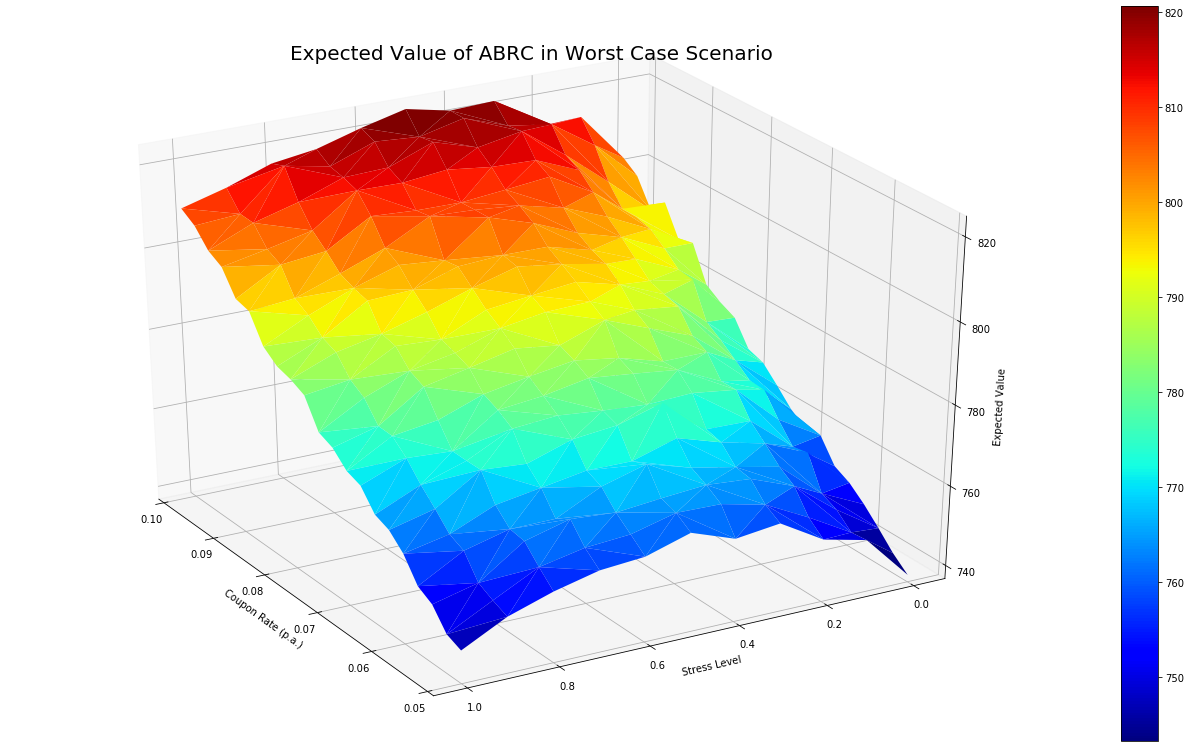

In [661]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')

Xs = triple2[:,0]
Ys = triple2[:,1]
Zs = triple2[:,2]

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

ax.set_xlabel('Coupon Rate (p.a.)')
ax.set_ylabel('Stress Level')
ax.set_zlabel('Expected Value');

ax.set_xlim((0.05,0.1))

ax.view_init(30, 150)
ax.set_title('Expected Value of ABRC in Worst Case Scenario', loc='center',fontsize= 20)
fig.tight_layout()

plt.show()
# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\worst_surface.png')